# Flux2 Optimization Tutorial: FORA + Quantization + Torch Compile

This tutorial demonstrates how to use **Pruna** to speed up image generation with Flux2 using a combination of three optimization techniques:

1. **FORA (Fast Output Reuse Acceleration)** - Caches transformer block outputs and reuses them for subsequent diffusion steps
2. **TorchAO Quantization (FP8)** - Reduces memory bandwidth by using 8-bit floating point weights
3. **Torch Compile** - JIT compiles the model for optimized GPU execution

Together, these optimizations can achieve **2-3x speedup** while maintaining image quality.

## Prerequisites
- NVIDIA GPU with CUDA support (compute capability ≥ 8.9 for FP8)
- `pruna` library installed (`pip install pruna`)
- `diffusers` with Flux2 support
- HuggingFace account with access to Flux2 models

## 1. Setup and Imports

In [ ]:
# Login to HuggingFace (required for Flux2 model access)
from huggingface_hub import login

# Replace with your HuggingFace token
HF_TOKEN = "your_hf_token_here"
login(token=HF_TOKEN)

/root/fluxnew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import copy
import gc
import matplotlib.pyplot as plt
from diffusers import Flux2KleinPipeline
from pruna import SmashConfig, smash

# Check CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"

/root/fluxnew/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
Multiple distributions found for package optimum. Picked distribution: optimum
/root/fluxnew/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


## 2. Load the Flux2 Model

We'll load the Flux2-Klein-Base-4B model. This is a 4 billion parameter model optimized for high-quality image generation.

**Important:** Do NOT use `enable_model_cpu_offload()` as it interferes with FORA's caching mechanism.

In [3]:
print("Loading Flux2 pipeline...")
pipe = Flux2KleinPipeline.from_pretrained(
    "black-forest-labs/FLUX.2-klein-base-4B", 
    torch_dtype=torch.bfloat16
)
print("Pipeline loaded!")

# NOTE: Do NOT use pipe.enable_model_cpu_offload()
# It breaks FORA's caching mechanism by re-initializing model hooks

Loading Flux2 pipeline...


Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Pipeline loaded!


## 3. Define Generation Parameters

Set up the common parameters for image generation. We'll use the same parameters for both baseline and FORA-optimized models to ensure a fair comparison.

In [4]:
# Generation parameters
prompt = "A humanoid robot or cyborg set against a bold red background"

gen_kwargs = dict(
    image=None,
    prompt=prompt,
    height=1024,
    width=1024,
    guidance_scale=4.0,
    num_inference_steps=50,
)

# Use same seed for reproducible results
def get_generator():
    return torch.Generator(device=device).manual_seed(42)

# FORA parameters
FORA_START_STEP = 4  # Start caching after this many steps
FORA_INTERVAL = 3    # Recompute every N steps (higher = faster but lower quality)

# Benchmarking parameters
NUM_WARMUP = 2  # Warmup runs (not timed)
NUM_TIMED = 3   # Timed runs for averaging

print(f"Prompt: {prompt}")
print(f"Image size: {gen_kwargs['height']}x{gen_kwargs['width']}")
print(f"Inference steps: {gen_kwargs['num_inference_steps']}")
print(f"FORA start_step: {FORA_START_STEP}, interval: {FORA_INTERVAL}")

Prompt: A humanoid robot or cyborg set against a bold red background
Image size: 1024x1024
Inference steps: 50
FORA start_step: 4, interval: 3


## 4. Benchmark Baseline (No Optimization)

First, let's measure the baseline performance without any FORA optimization.

In [5]:
# Move pipeline to GPU
pipe.to("cuda")

# ============================================================
# BASELINE: Warmup then Measure
# ============================================================
print(f"--- Warming up BASELINE ({NUM_WARMUP} runs) ---")
for i in range(NUM_WARMUP):
    print(f"  Warmup {i+1}/{NUM_WARMUP}...")
    _ = pipe(**gen_kwargs, generator=get_generator())
torch.cuda.synchronize()
print("Baseline warmup complete.")

print(f"\n--- Timing BASELINE ({NUM_TIMED} runs) ---")
baseline_times = []
for i in range(NUM_TIMED):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    image_baseline = pipe(**gen_kwargs, generator=get_generator()).images[0]
    end_event.record()
    torch.cuda.synchronize()
    
    elapsed = start_event.elapsed_time(end_event) / 1000  # ms to seconds
    baseline_times.append(elapsed)
    print(f"  Run {i+1}: {elapsed:.2f}s")

avg_baseline = sum(baseline_times) / len(baseline_times)
print(f"\nBaseline average: {avg_baseline:.2f}s")

--- Warming up BASELINE (2 runs) ---
  Warmup 1/2...


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


  Warmup 2/2...


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Baseline warmup complete.

--- Timing BASELINE (3 runs) ---


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


  Run 1: 16.09s


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


  Run 2: 16.11s


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


  Run 3: 16.15s

Baseline average: 16.12s


## 5. Create Optimized Model (FORA + Quantization + Compile)

Now we'll create an optimized model using Pruna's `smash` function with three techniques:

### FORA Parameters:
- **`fora_interval`**: How often to recompute transformer outputs (higher = faster, but lower quality)
- **`fora_start_step`**: Number of initial steps to run without caching (higher = better quality early steps)
- **`fora_backbone_calls_per_step`**: Set to 2 for Classifier-Free Guidance (CFG)

### TorchAO Quantization:
- **`quant_type: fp8wo`**: FP8 weight-only quantization - reduces memory bandwidth while keeping activations in full precision
- **`target_modules`**: Specify which layers to quantize (we target `single_transformer_blocks` and exclude norms/embeddings)

### Torch Compile:
- **`torch_compile: True`**: Enables JIT compilation for optimized GPU kernels

In [ ]:
# ============================================================
# Create optimized model with FORA + Quantization + Compile
# ============================================================
print("--- Creating optimized model ---")

smash_config = SmashConfig({
    # FORA: Cache and reuse transformer outputs
    "fora": {
        "fora_interval": FORA_INTERVAL,
        "fora_start_step": FORA_START_STEP,
        "fora_backbone_calls_per_step": 2,  # 2 for CFG (conditional + unconditional)
    },
    # TorchAO: FP8 weight-only quantization for reduced memory bandwidth
    "torchao": {
        "quant_type": "fp8wo",
        "target_modules": {
            "include": ["*single_transformer_blocks.*"],  # Quantize single-stream blocks
            "exclude": ["pe_embedder", "*norm*", "*embed*"]  # Skip norms and embeddings
        },
    },
    # Torch Compile: JIT compilation for optimized kernels
    "torch_compile": True
})

# Create a deep copy of the pipeline and apply optimizations
smashed_model = smash(model=copy.deepcopy(pipe), smash_config=smash_config)
print("Optimized model created!")

## 6. Benchmark Optimized Model

Note: The first warmup run will be slower due to torch.compile JIT compilation. Subsequent runs show the true optimized performance.

In [ ]:
# ============================================================
# Optimized Model: Warmup then Measure
# ============================================================
print(f"--- Warming up optimized model ({NUM_WARMUP} runs) ---")
print("(First run includes torch.compile JIT compilation overhead)")
for i in range(NUM_WARMUP):
    print(f"  Warmup {i+1}/{NUM_WARMUP}...")
    _ = smashed_model(**gen_kwargs, generator=get_generator())
torch.cuda.synchronize()
print("Warmup complete.")

print(f"\n--- Timing optimized model ({NUM_TIMED} runs) ---")
fora_times = []
for i in range(NUM_TIMED):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    image_fora = smashed_model(**gen_kwargs, generator=get_generator()).images[0]
    end_event.record()
    torch.cuda.synchronize()
    
    elapsed = start_event.elapsed_time(end_event) / 1000  # ms to seconds
    fora_times.append(elapsed)
    print(f"  Run {i+1}: {elapsed:.2f}s")

avg_fora = sum(fora_times) / len(fora_times)
print(f"\nOptimized average: {avg_fora:.2f}s")

--- Warming up FORA (2 runs) ---
  Warmup 1/2...


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


  Warmup 2/2...


100%|██████████| 50/50 [00:05<00:00,  9.16it/s]


FORA warmup complete.

--- Timing FORA (3 runs) ---


100%|██████████| 50/50 [00:05<00:00,  9.12it/s]


  Run 1: 5.94s


100%|██████████| 50/50 [00:05<00:00,  9.10it/s]


  Run 2: 5.96s


100%|██████████| 50/50 [00:05<00:00,  9.08it/s]


  Run 3: 5.97s

FORA average: 5.96s


## 7. Results Comparison

In [ ]:
# ============================================================
# Results Summary
# ============================================================
speedup = avg_baseline / avg_fora

print(f"\n{'='*60}")
print(f"RESULTS: FORA + FP8 Quantization + Torch Compile")
print(f"{'='*60}")
print(f"FORA: start_step={FORA_START_STEP}, interval={FORA_INTERVAL}")
print(f"Quantization: FP8 weight-only on single_transformer_blocks")
print(f"{'='*60}")
print(f"Baseline:   {avg_baseline:.2f}s")
print(f"Optimized:  {avg_fora:.2f}s")
print(f"Speedup:    {speedup:.2f}x")
print(f"Time saved: {avg_baseline - avg_fora:.2f}s per image")
print(f"{'='*60}")


RESULTS (start_step=4, interval=3)
Baseline:  16.12s
FORA:      5.96s
Speedup:   2.70x
Time saved: 10.16s per image


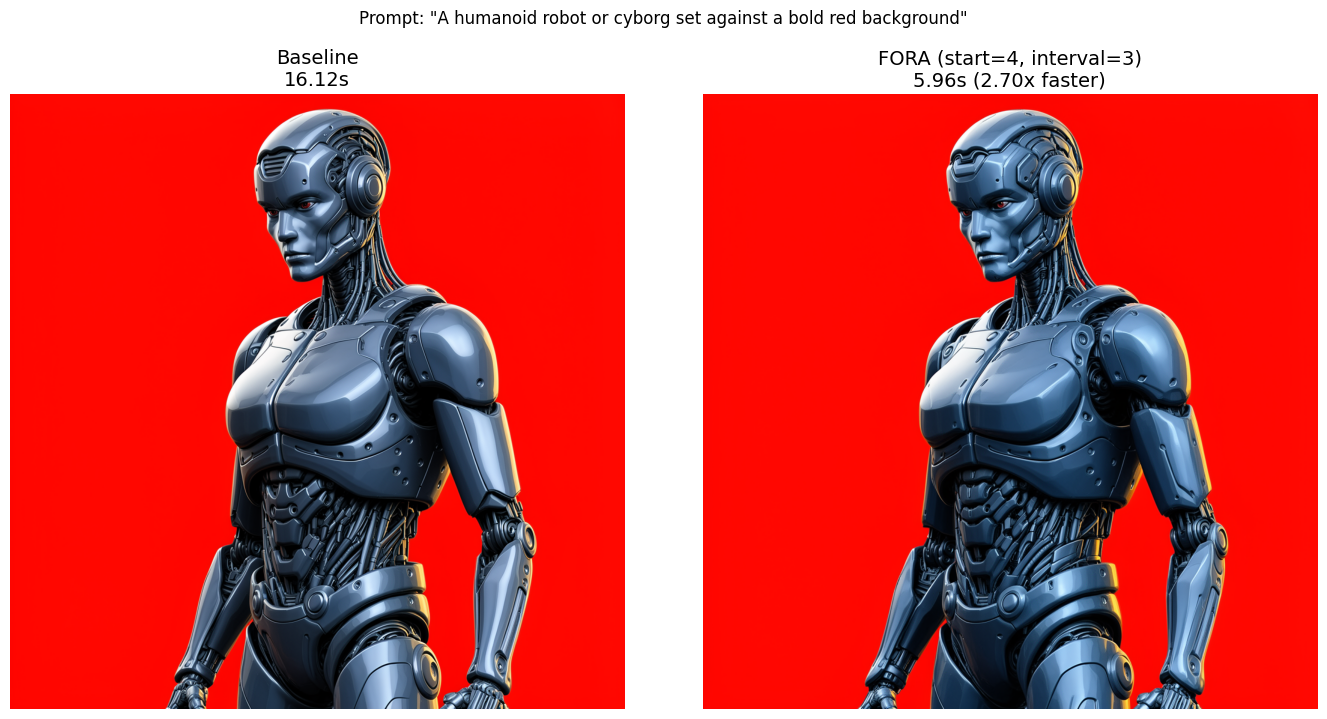

In [ ]:
# ============================================================
# Visual Comparison
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(image_baseline)
axes[0].set_title(f"Baseline\n{avg_baseline:.2f}s", fontsize=14)
axes[0].axis("off")

axes[1].imshow(image_fora)
axes[1].set_title(f"Optimized (FORA + FP8 + Compile)\n{avg_fora:.2f}s ({speedup:.2f}x faster)", fontsize=14)
axes[1].axis("off")

plt.suptitle(f'Prompt: "{prompt}"', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("baseline_vs_fora.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Cleanup

In [10]:
# Free GPU memory
del smashed_model
torch.cuda.empty_cache()
gc.collect()
print("Cleanup complete!")

Cleanup complete!
